In [1]:
%pylab inline
from JSAnimation import IPython_display
from matplotlib import animation
from __future__ import print_function
import time
from channels import *
from compartment import *
from membrane import *
from params import *

from csdmodel1d import *

import numpy as np
np.seterr(all='ignore')
from scipy.integrate import ode

Populating the interactive namespace from numpy and matplotlib


In [2]:
model = CSDModelInterval(N=32,dx=5e-6) # define the model

# Define the compartments, and the membranes
ecs = Compartment("ecs")
neuron = CellCompartment("neuron",density = 2e5) # 2e5 neurons per meter, 4e10 per sq meter
glia = CellCompartment("glia",density = 2e5) #2e5 glia per meter

neuron_mem = Membrane("neuronal",inside=neuron,outside=ecs,Cm=Cn,phi_m=-70e-3)
glial_mem = Membrane("glial",inside=glia,outside=ecs,Cm=Cg,phi_m=-85e-3)

# Add the compartments to the model
model.addCompartment(ecs,fraction=0.2) # ECS take 20% of the total volume
model.addCompartment(neuron,fraction=0.4) # Neurons take up 40% of the total volume
model.addCompartment(glia,fraction=0.4) # Neurons take up 40% of the total volume

# Add ion species
ecs.addSpecies(K,Ke0,name='K_e')
ecs.addSpecies(Cl,Cle0,name='Cl_e')
ecs.addSpecies(Na,Nae0,name='Na_e')
ecs.addSpecies(Ca,Cae0,name='Ca_e')
ecs.addSpecies(Glu,0.0,name = "g_e")

neuron.addSpecies(K,Ki0,0,'K_n')
neuron.addSpecies(Na,Nai0,0,'Na_n')
neuron.addSpecies(Cl,Cli0,0,'Cl_n')
neuron.addSpecies(Ca,Cai0,0,'Ca_n')
neuron.addSpecies(Glu,1e-6,name = "g_n")


glia.addSpecies(K,Ki0,name='K_g')
glia.addSpecies(Na,Nai0,name='Na_g')
glia.addSpecies(Cl,Cli0,name='Cl_g')
glia.addSpecies(Ca,Cai0,0,'Ca_g')

# add channels
neuron_mem.addChannel(NaTChannel(),10000.) # 100 per neuron?
neuron_mem.addChannel(NaPChannel(),200.) # 2 per neuron
neuron_mem.addChannel(KDRChannel(),10000.) # number of channels per neuron
neuron_mem.addChannel(KIRChannel(),10000.)
#neuron_mem.addChannel(NMDAChannel(),10.)
neuron_mem.addChannel(gNMDAChannel(),1000.)

neuron_mem.addChannel(PMCAPump(),20000) # PMCA pump
neuron_mem.addChannel(NaCaExchangePump(),20000) # sodium-calcium exchanger
neuron_mem.addChannel(NaKATPasePump(),500000.) # 5000 ATPase per neuron
neuron_mem.addChannel(NonSpecificChlorideChannel(-0.07),40000)

glial_mem.addChannel(KIRChannel(),10000) # KIR Channel
glial_mem.addChannel(NaKATPasePump(),500000.) # 5000 ATPase per neuron
glial_mem.addChannel(PMCAPump(),20000)
glial_mem.addChannel(NonSpecificChlorideChannel(-0.085),10000)

model.addMembrane(neuron_mem)
model.addMembrane(glial_mem)

neuron_mem.addLeakChannels()
neuron.balanceWith(ecs)
glial_mem.addLeakChannels()
glia.balanceWith(ecs)

model.assembleSystem()

system_state = model.getInternalVars()

Ion: Cl-, g_leak: 0.00E+00
Ion: Na+, g_leak: 2.99E-04
Ion: K+, g_leak: 1.33E-03
Ion: Ca2+, g_leak: 7.85E-04
Adding a leak channel does nothing to balance Cl-
Ion: Na+, g_leak: 3.49E-04
Ion: K+, g_leak: 2.96E-03
Ion: Ca2+, g_leak: 7.42E-04


We're going to poke some holes into the membranes in order to instigate CSD

In [3]:
'''
#Hole method for initiation - very slow!!
neuron_hole = HoleChannel([K,Na,Cl],1e-6)
density = np.zeros(model.N)
density[0:3] = 10
neuron_mem.addChannel(neuron_hole,density)

glial_hole = HoleChannel([K,Na,Cl],1e-6)
glial_mem.addChannel(glial_hole,density)
'''

ecs.values[K][:3] += .060
y = model.getInternalVars()
model.odesolver.set_initial_value(y,0)

In [4]:
t_old = 0
model.odesolver.t = 0
dt1 = 0 # timescale separation
t_old1 = 0
system_states = []
t = []
meanflux = 0.0
t.append(0)
start_time = time.time()

#print( "%s\t\t%s\t%s\t%s, %s, %s, %s" % ('time', 'V_n','V_g', 'K_e', 'K_n','K_g','Cl_e'))
print('{:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}'.format('time', 'V_n','V_g', 'K_e', 'K_n','K_g','Cl_e') )
#print("%.3fs\t%.2fmV%.2fmV, %.2fmM, %.2fmM, %.2fmM, %.2fmM" % (model.odesolver.t, 1e3*neuron_mem.phi()[0], 1e3*glial_mem.phi()[0], 1e3*ecs.value(K)[0], 1e3*neuron.value(K)[0], 1e3*glia.value(K)[0], 1e3*ecs.value(Cl)[0]), end='\r')
print('{:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}'.format(model.odesolver.t, 1e3*neuron_mem.phi()[0], 1e3*glial_mem.phi()[0], 1e3*ecs.value(K)[0], 1e3*neuron.value(K)[0], 1e3*glia.value(K)[0], 1e3*ecs.value(Cl)[0]), end='\r')

while model.odesolver.successful() and model.odesolver.t < 30.0:
    y = model.odesolver.integrate(model.odesolver.t+1e-2)
    #print( "%.3fs\t%.2fmV,%.2fmV, %.2fmM, %.2fmM, %.2fmM, %.2fmM" % (model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0]), end='\r')
    print('{:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0]), end='\r')
    system_states.append(y)
    t.append(model.odesolver.t)
    
   
print('{:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0]))
elapsed_time = time.time() - start_time
print('{:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0]))
print("\nElapsed time %.3f" % (elapsed_time) )

      time        V_n        V_g        K_e        K_n        K_g       Cl_e
      30.0 -63.5096948597 -71.777879965 7.34781531322 133.539698497 133.538740216 145.499992532
      30.0 -63.5096948597 -71.777879965 7.34781531322 133.539698497 133.538740216 145.499992532

Elapsed time 1351.235



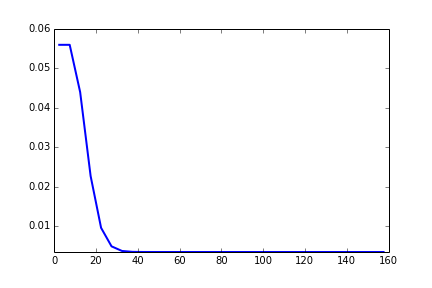
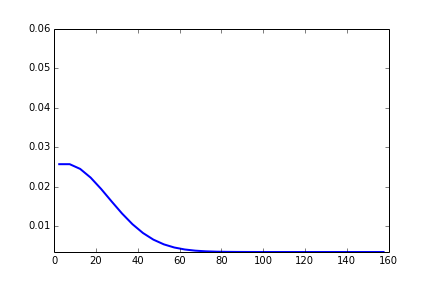
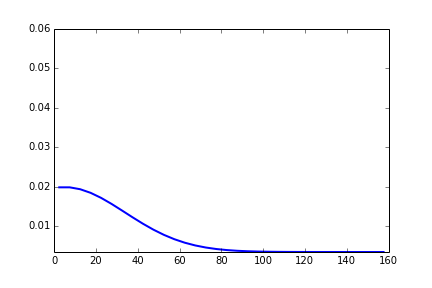
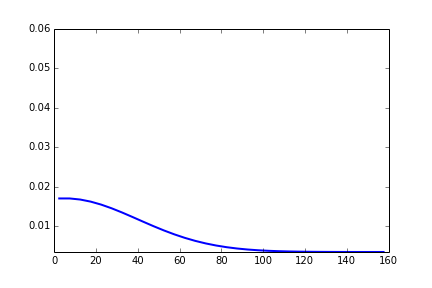
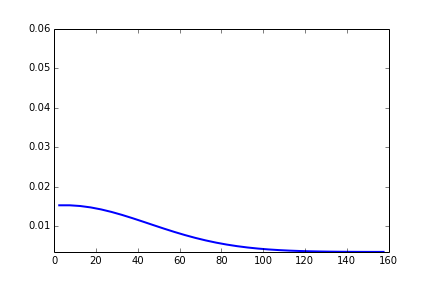
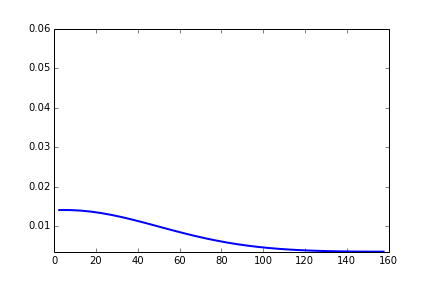
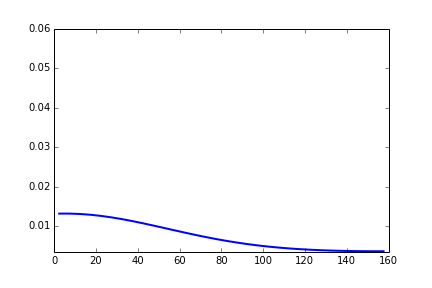
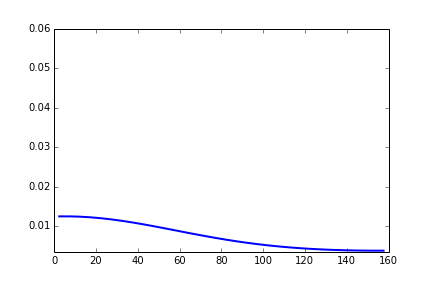
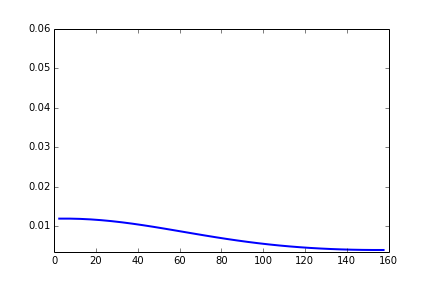
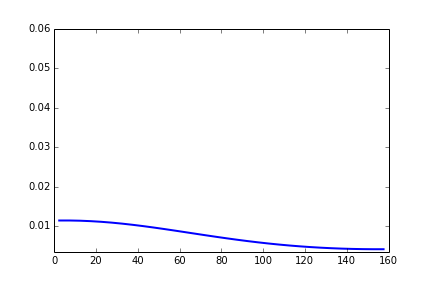
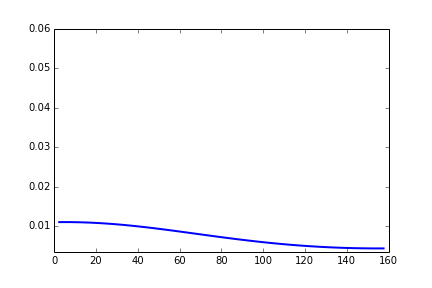
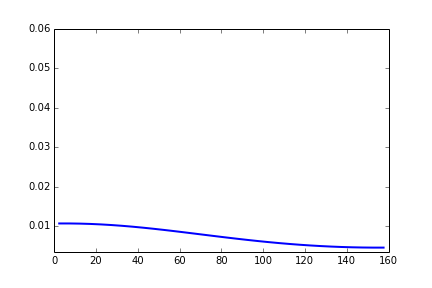
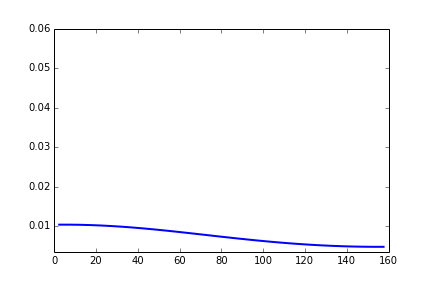
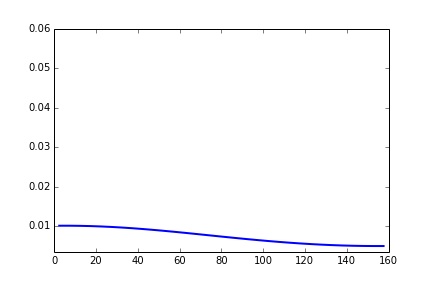
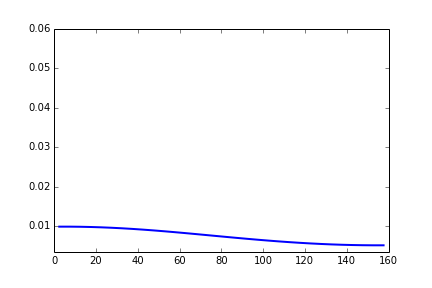
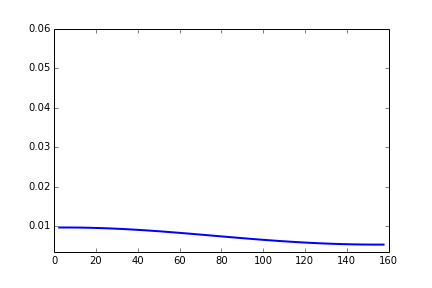
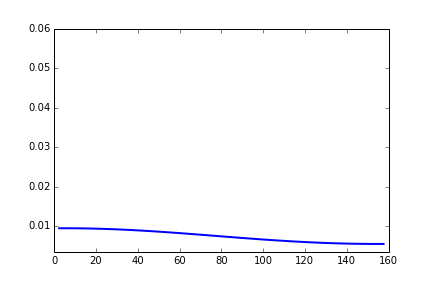
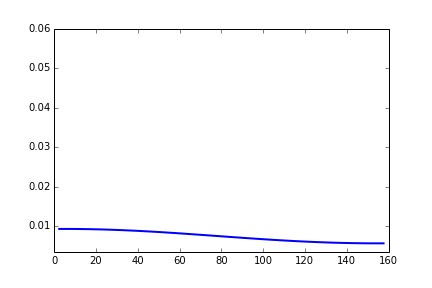
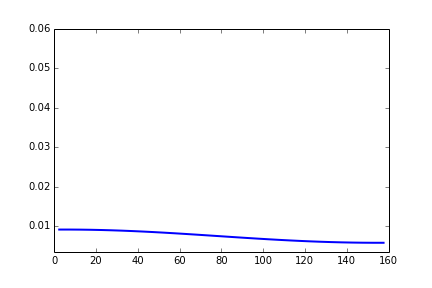
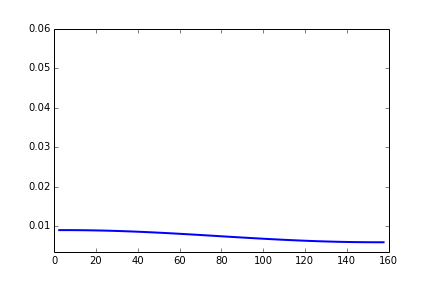
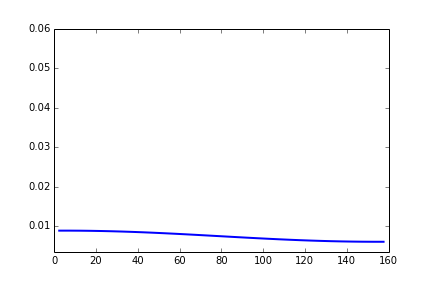
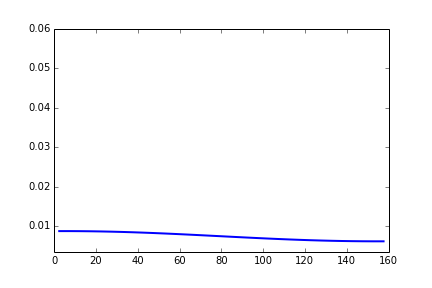
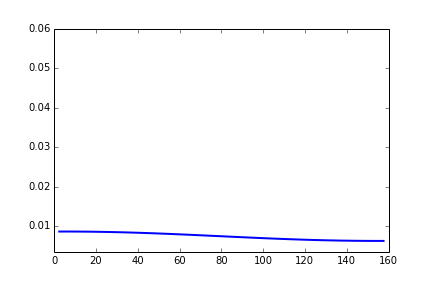
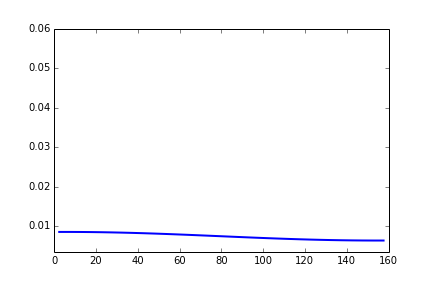
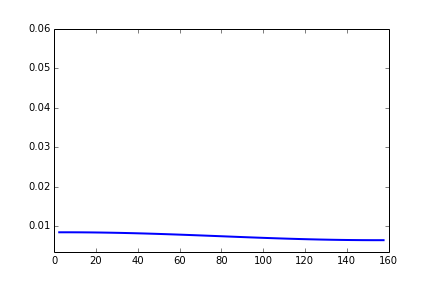
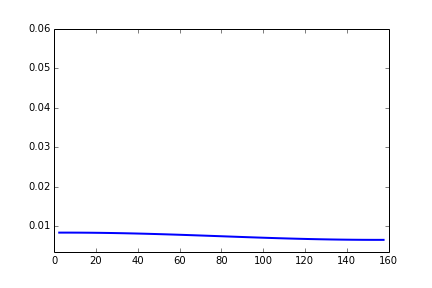
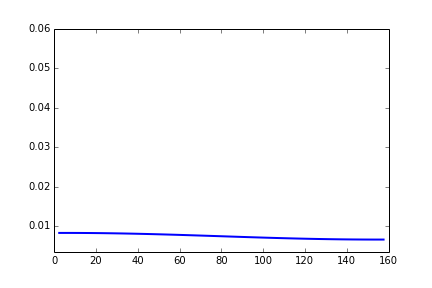
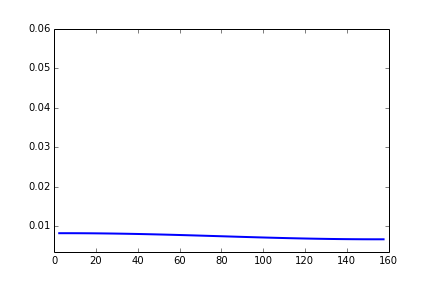
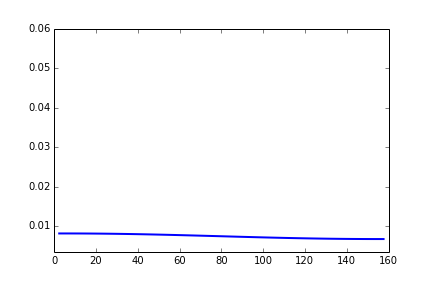
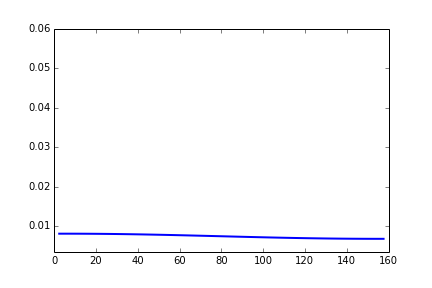
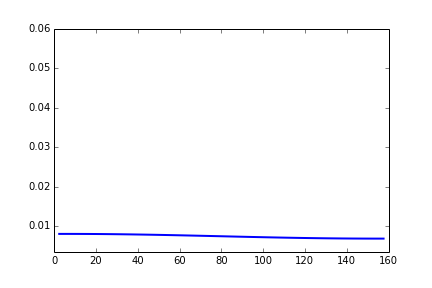
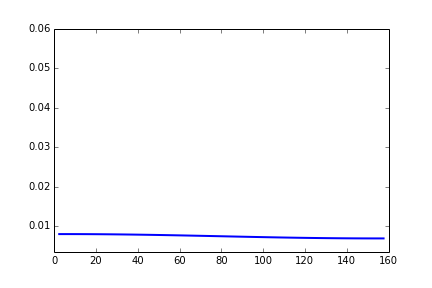
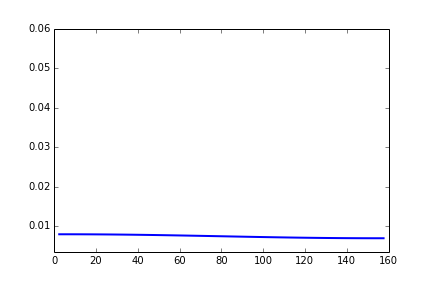
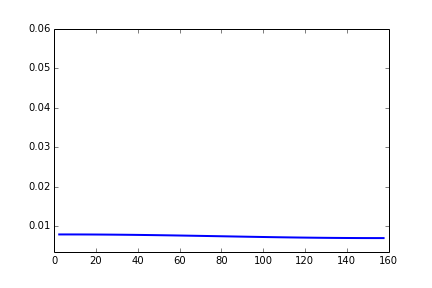
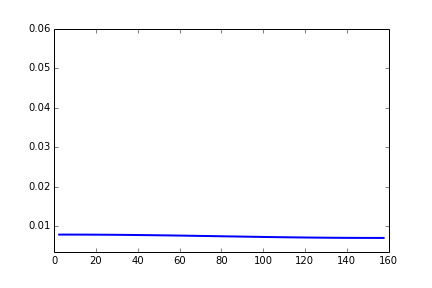
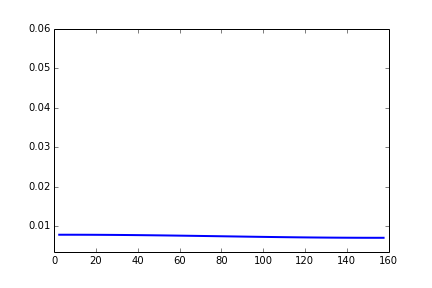
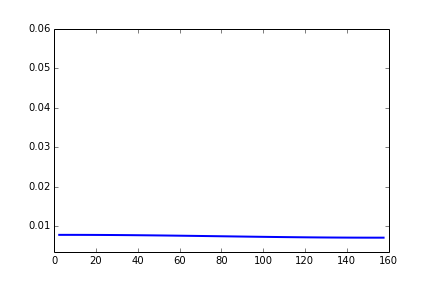
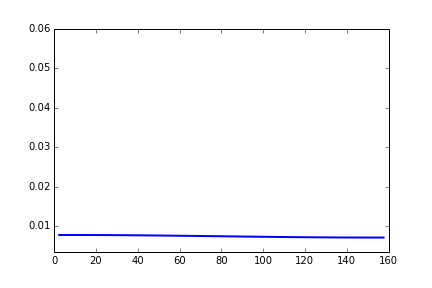
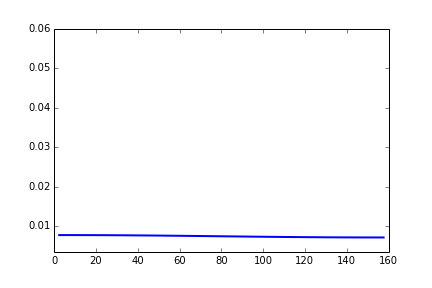
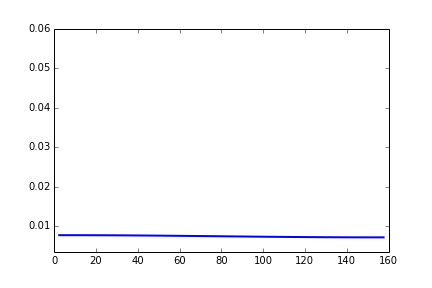
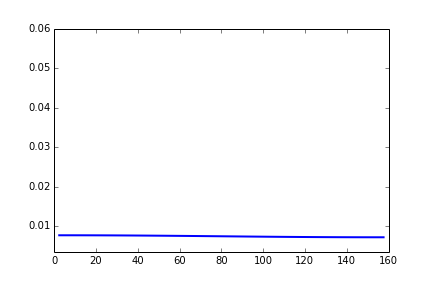
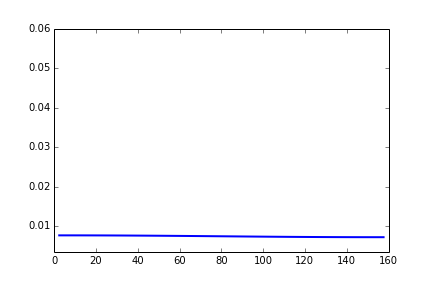
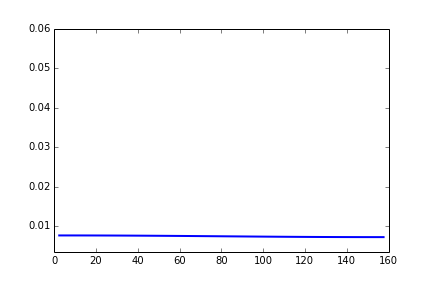
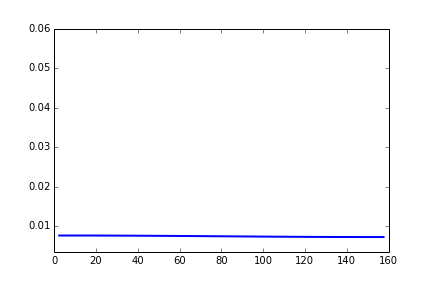
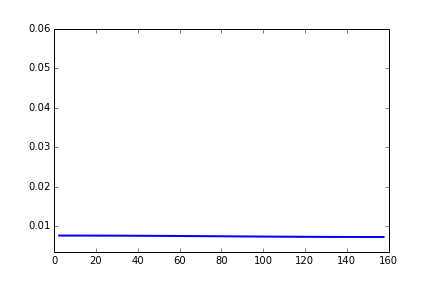
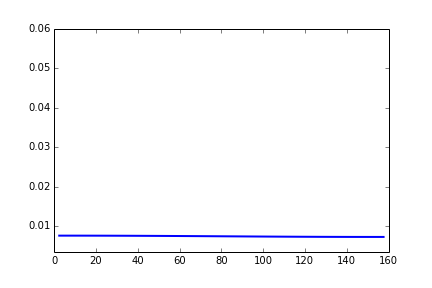
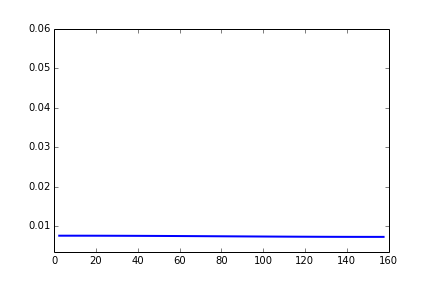
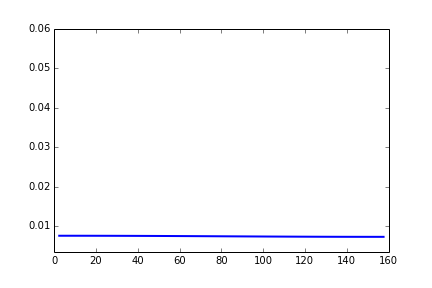
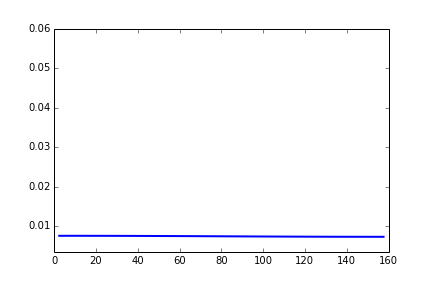
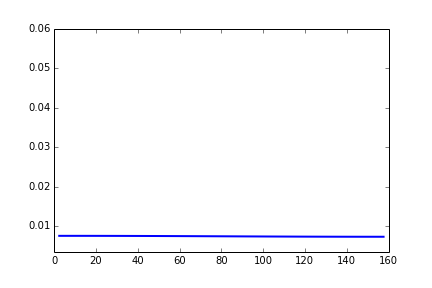
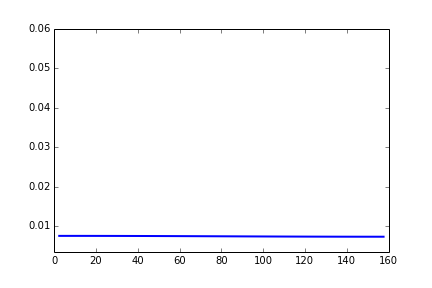
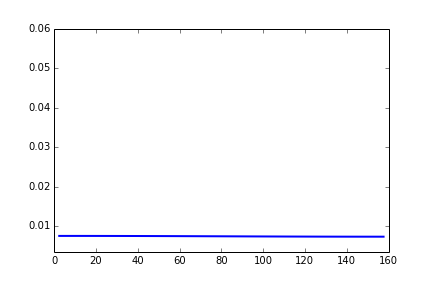
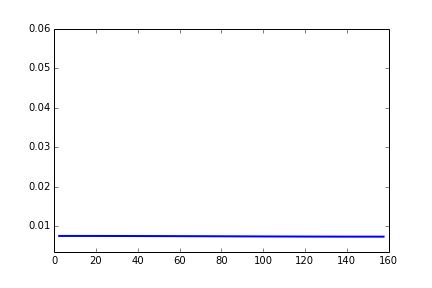
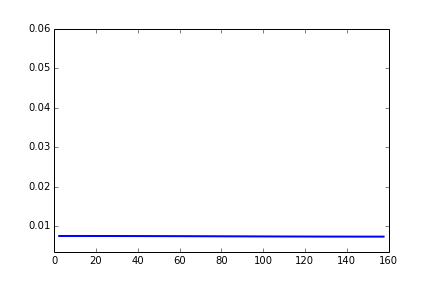
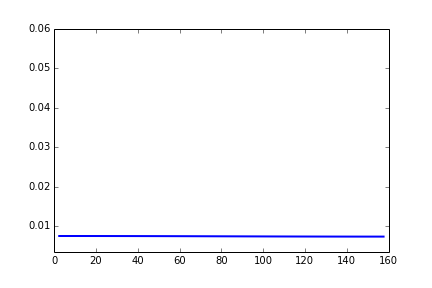
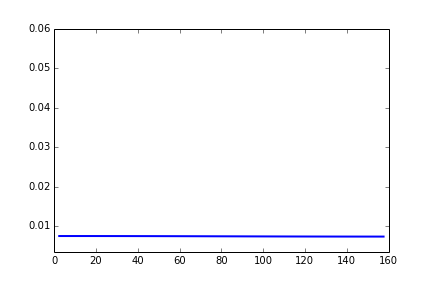
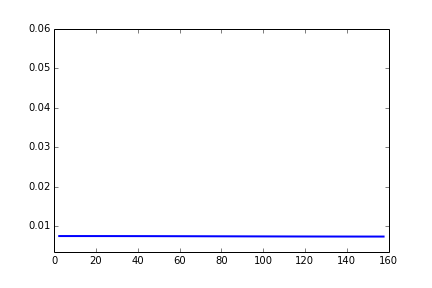
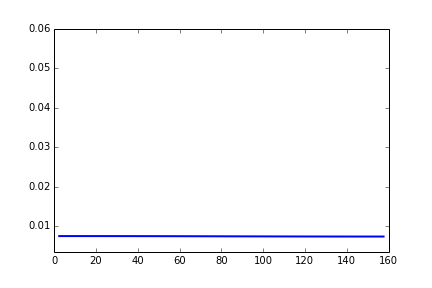
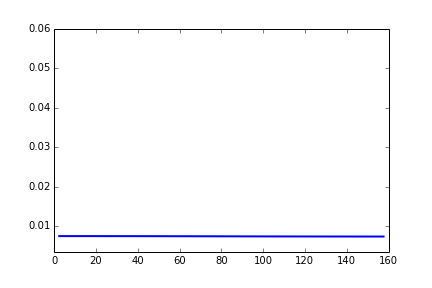
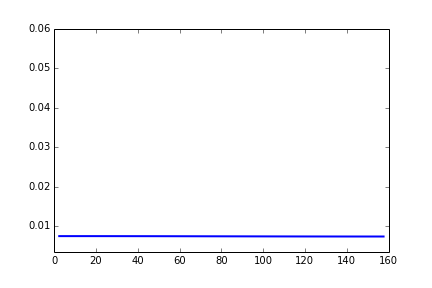
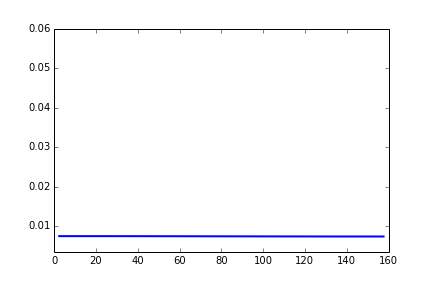
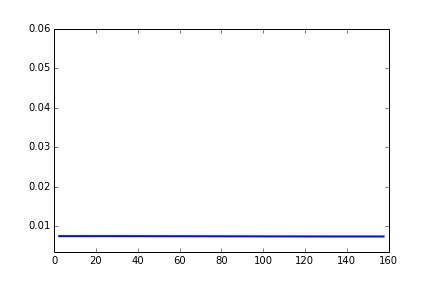
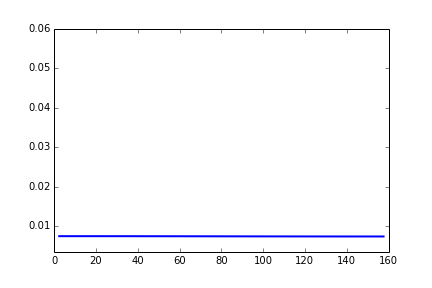
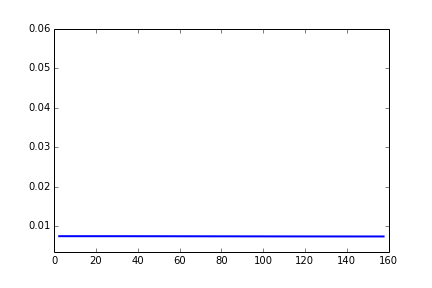
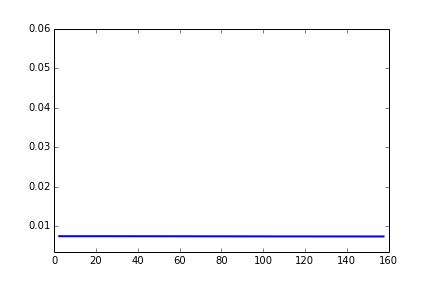
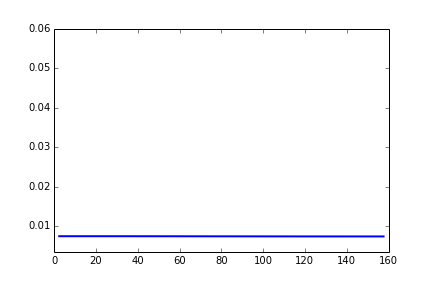
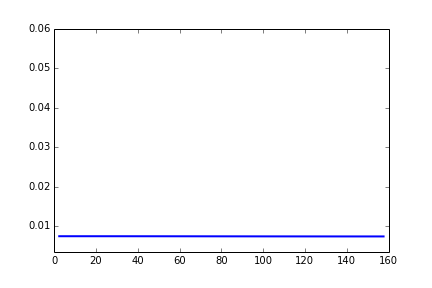
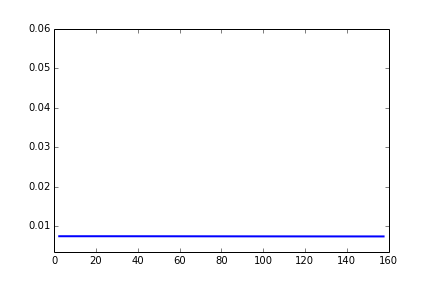
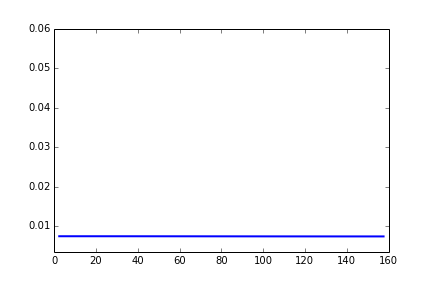
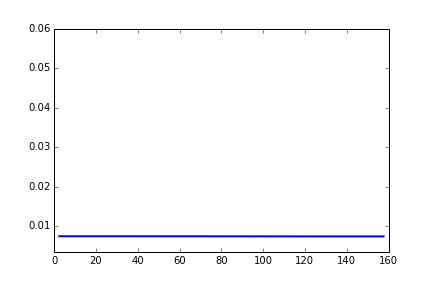
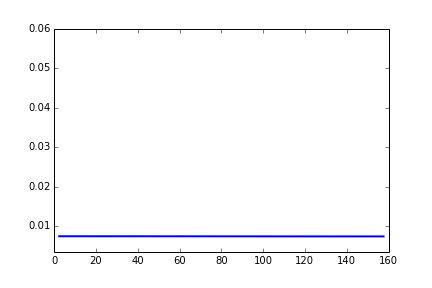
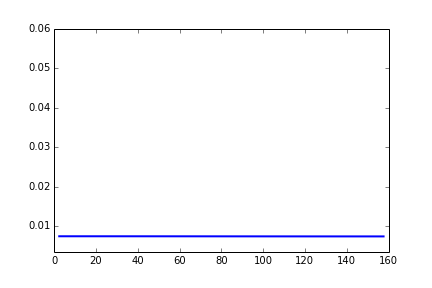
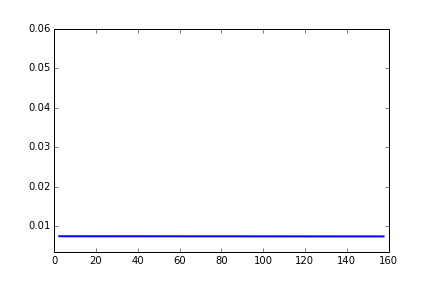
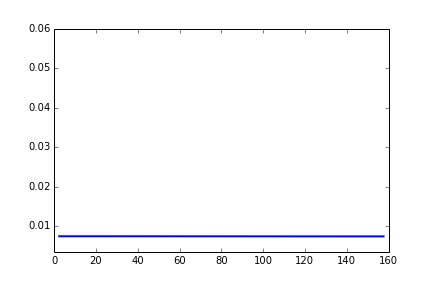
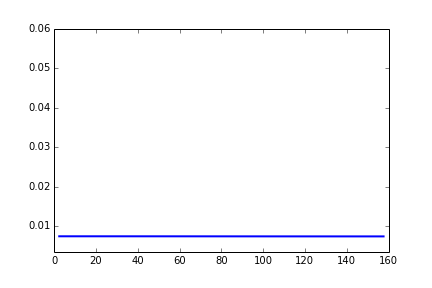
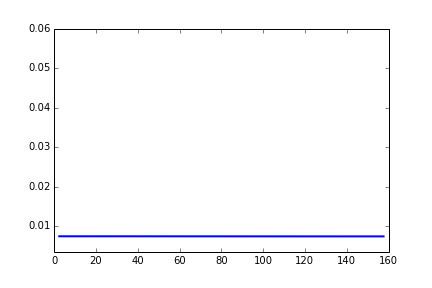
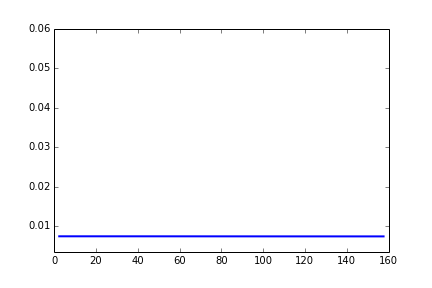
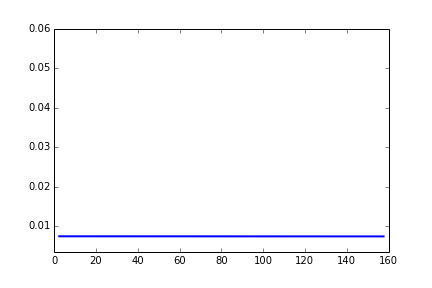
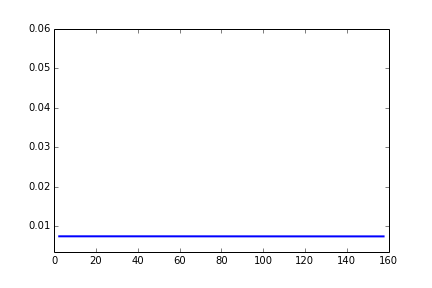
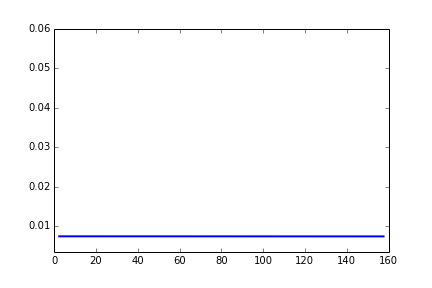
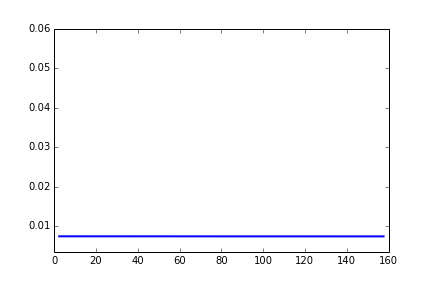
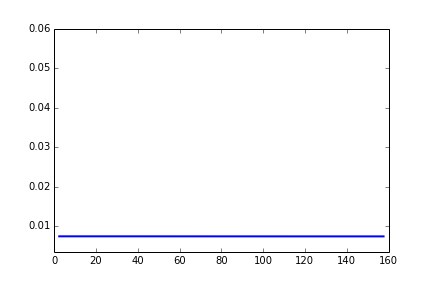
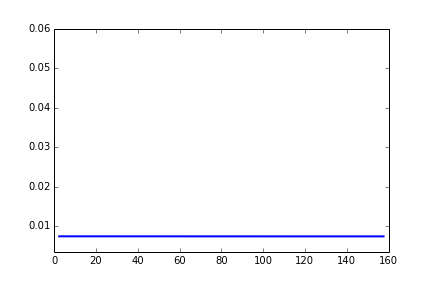
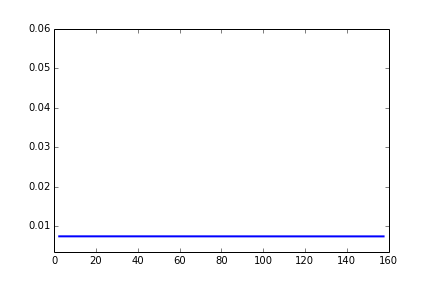
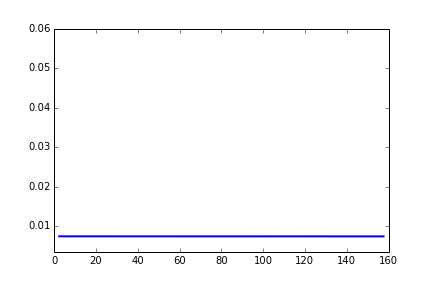
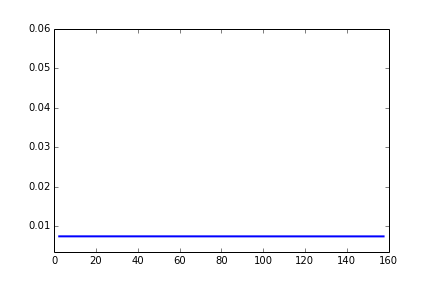
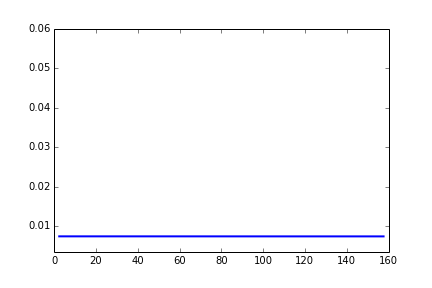
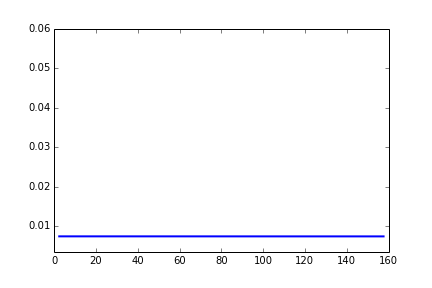
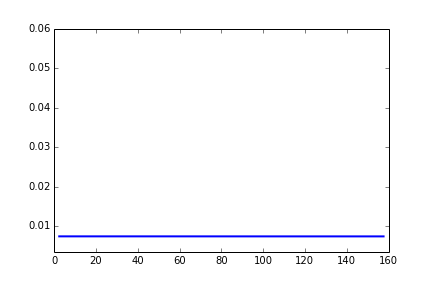
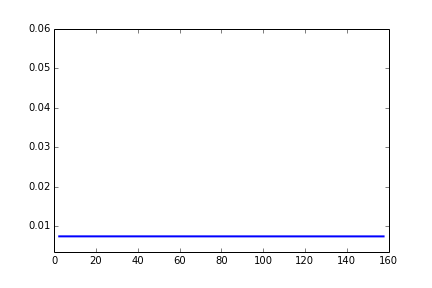
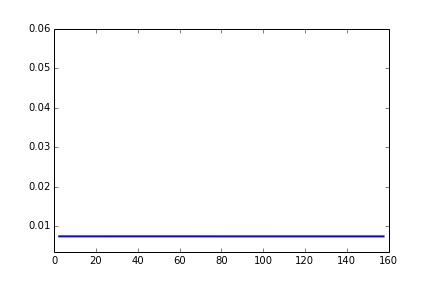
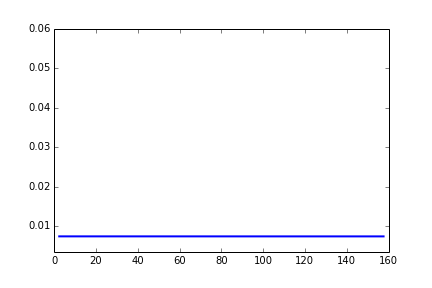
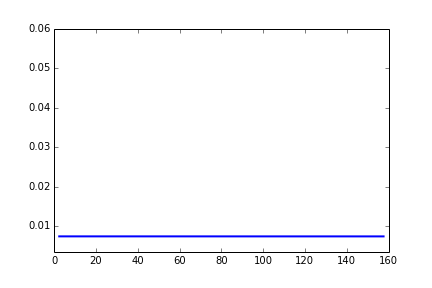
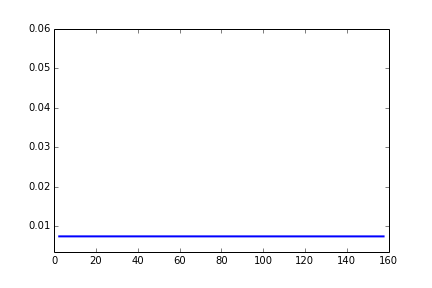
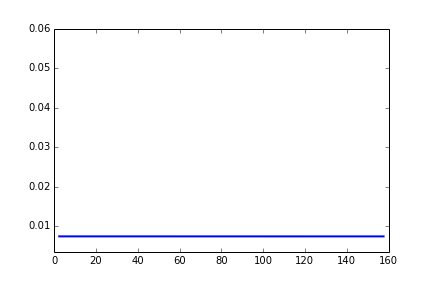
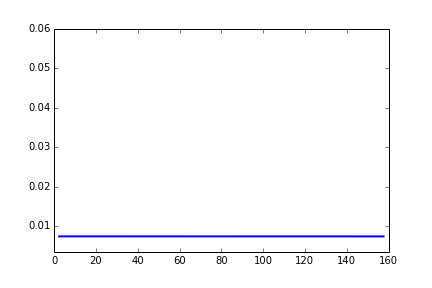
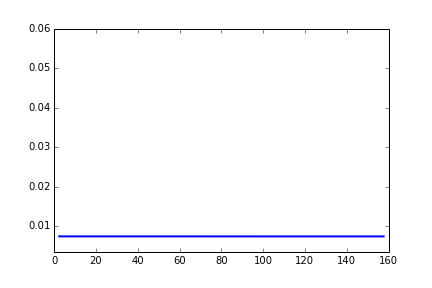
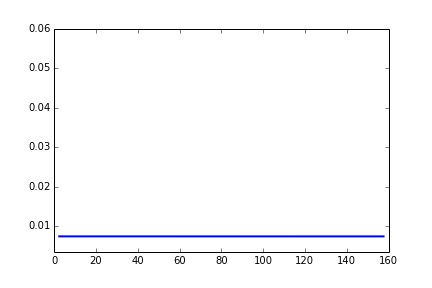
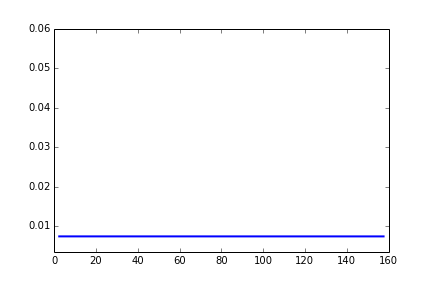
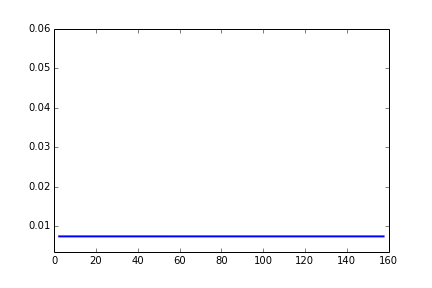

In [6]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 160), ylim=(3.5e-3, 60e-3))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(model.x*1e6,ecs.value(K,system_states[10*i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=100, interval=20, blit=True)